In [1]:
!pip install pyarrow
!pip install mxnet
!pip install --upgrade pip
!pip install scikit-plot
!pip install --upgrade gap-stat
from cluster_funciones import *
%matplotlib inline

    100% |████████████████████████████████| 58.2MB 810kB/s eta 0:00:01
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 25.4MB 1.9MB/s eta 0:00:01
    100% |████████████████████████████████| 20.4MB 3.1MB/s eta 0:00:01
  Found existing installation: numpy 1.14.3
    Uninstalling numpy-1.14.3:
      Successfully uninstalled numpy-1.14.3
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
    100% |████████████████████████████████| 1.4MB 17.4MB/s ta 0:00:01
  Found existing installation: pip 10.0.1
    Uninstalling pip-10.0.1:
      Successfully uninstalled pip-10.0.1
     |████████████████████████████████| 286kB 29.7MB/s eta 0:00:01
     |████████████████████████████████| 1.6MB 20.2MB/s eta 0:00:01


In [2]:
bucket = Session().default_bucket()
s3 = s3fs.S3FileSystem()
seed = 1234

In [3]:
data = pq.ParquetDataset('s3://prosegur-sbx-data/sagemaker-datasets/events/history', filesystem=s3).read(use_threads = False).to_pandas()

In [4]:
data = pre_process(data)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [5]:
data.to_csv('../data/tmp_cluster/dataset.csv', index = False)

In [6]:
original_dataset = pd.read_csv('../data/tmp_cluster/dataset.csv')

In [7]:
original_contracts = pq.ParquetDataset('s3://prosegur-sbx-data/data-experimento-ds/data-simple-cnn/raw/caract_contratos_mapeo.parquet', filesystem=s3).read(use_threads = False).to_pandas()

In [8]:
structured_dataset_with_config = make_structured_dataset(data, original_contracts)
#structured_dataset_with_config.to_csv('../data/tmp_cluster/structured_dataset_extended_from_function.csv', index = False)

In [9]:
structured_dataset_with_config.to_csv('data_frame_trabajable.csv', index = False)

In [2]:
df = pd.read_csv('data_frame_trabajable.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data_train = df.drop(labels = ['client_id', 'events'], axis = 1).values.astype('float32')

In [ ]:
#========================================DETECTANDO OUTLIERS===============================================

In [4]:
iso_forest = IsolationForest(contamination = 0.001, random_state = 1234, behaviour = "new")

In [5]:
iso_forest.fit(df.drop(['client_id'], 1))

IsolationForest(behaviour='new', bootstrap=False, contamination=0.001,
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=1234, verbose=0)

In [6]:
outlier_pred = iso_forest.predict(df.drop(['client_id'], 1))
outlier_pred = [False if x == 1 else True for x in outlier_pred]
pd.Series(outlier_pred).value_counts()

False    100231
True        101
dtype: int64

In [ ]:
#====================================SCKIT-LEARN K-MEANS==================================================

In [15]:
scaled_clients = StandardScaler().fit_transform(df.drop(['client_id', 'events'], axis = 1))
scaled_clients_df = pd.DataFrame(scaled_clients)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


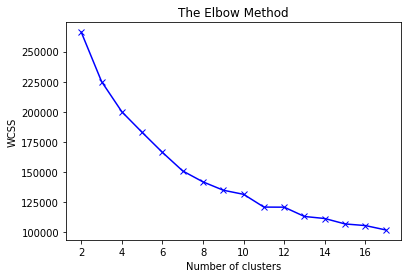

In [16]:
#ELBOW with data_train without scaling
clusters = range(2, 18)
kmeanslist = []
WCSS = [] #Within-Cluster Sum-Squares metric


for cluster in clusters:
    kmeans = KMeans(n_clusters = cluster, init = 'k-means++', random_state = 1)
    kmeans.fit(data_train)
    WCSS.append(kmeans.inertia_)
    kmeanslist.append(kmeans)

    
plt.plot(clusters, WCSS, 'bx-')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
#===================================SIlhouette MEtric========================================

In [9]:
clusters = range(2, 18)
SS = [] #Silhouette metric list
results = {}

for cluster in clusters:
    kmeans = KMeans(n_clusters = cluster, init = 'k-means++', random_state = 1)
    kmeans.fit(data_train)
    cluster_pred = kmeans.fit_predict(data_train)
    results[cluster] = cluster_pred
    score = silhouette_score(data_train, labels = cluster_pred, metric='euclidean')
    SS.append(score)
    print('El SS para {} clusters es de {:.3f}'.format(cluster, score))

El SS para 2 clusters es de 0.963
El SS para 3 clusters es de 0.184
El SS para 4 clusters es de 0.232
El SS para 5 clusters es de 0.205
El SS para 6 clusters es de 0.239
El SS para 7 clusters es de 0.237
El SS para 8 clusters es de 0.244
El SS para 9 clusters es de 0.261
El SS para 10 clusters es de 0.248
El SS para 11 clusters es de 0.285
El SS para 12 clusters es de 0.270
El SS para 13 clusters es de 0.255
El SS para 14 clusters es de 0.253
El SS para 15 clusters es de 0.232
El SS para 16 clusters es de 0.222
El SS para 17 clusters es de 0.240


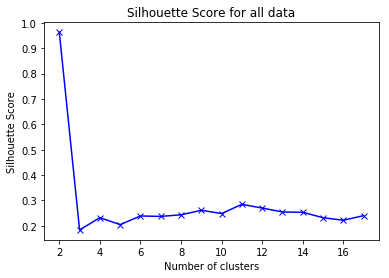

In [18]:
plt.plot(clusters, SS, 'bx-')
plt.title('Silhouette Score for all data')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [21]:
clusters_clients = pd.DataFrame({'client_id' : df.client_id,**{'{}_clusters'.format(k) : v for k,v in results.items()}})
clusters_clients.to_csv('clustering_results.csv', index = False)                                   

In [24]:
empaquetado = pd.read_csv('clustering_results.csv')

In [35]:
empaquetado['2_clusters'].value_counts()

0    100315
1        17
Name: 2_clusters, dtype: int64

In [39]:
empaquetado.sort_values('2_clusters', ascending=False).head(17)

,client_id,2_clusters,3_clusters,4_clusters,5_clusters,6_clusters,7_clusters,8_clusters,9_clusters,10_clusters,11_clusters,12_clusters,13_clusters,14_clusters,15_clusters,16_clusters,17_clusters
11817,047080,1,1,2,2,1,6,3,4,2,9,6,3,9,3,1,5
2911,0179325,1,1,2,1,1,4,2,6,6,6,2,11,7,11,8,7
17112,0626954,1,1,2,2,1,6,3,4,2,2,2,3,2,6,1,5
1538,011605,1,1,2,2,1,4,2,6,2,2,2,11,2,6,8,7
3857,021928,1,1,2,2,1,4,2,6,2,2,2,11,2,6,8,7
144,0013761,1,1,2,1,1,4,2,6,6,6,2,11,7,11,8,7
39705,1-237404045,1,1,2,1,1,4,2,6,6,2,2,11,2,6,8,7
10835,0440739,1,1,2,2,1,6,3,4,2,2,2,3,2,6,8,5
95857,460703,1,1,2,2,1,4,2,6,2,2,2,11,2,6,8,7
40894,1-307815945,1,1,2,2,1,4,2,6,2,2,2,11,2,6,8,7


In [46]:
df_plus_2clusters = pd.concat([df, empaquetado['2_clusters']], axis=1)
df_plus_2clusters.sort_values('2_clusters', ascending=False).head(20)


,client_id,dawn,morning,afternoon,evening,weekday,weekend,early_month,midearly_month,midlate_month,...,codigo_subtipo_local_unifamiliar,codigo_regimen_venta,antiguedad,precio_alta_mean_scaled,precio_alta_max_scaled,precio_alta_sum_scaled,contracts_count,events,scaled_events,2_clusters
11817,047080,0.009396,0.419414,0.170510,0.400680,0.816982,0.183018,0.283030,0.267120,0.222389,...,0.0,0.0,0.642605,0.012281,0.135605,0.335345,1.0,17348,84.032884,1
2911,0179325,0.049934,0.459190,0.028368,0.462508,0.963670,0.036330,0.267253,0.273225,0.229263,...,0.0,1.0,0.589649,0.011622,0.022334,0.072398,1.0,6028,28.893544,1
17112,0626954,0.222540,0.260487,0.215822,0.301151,0.723290,0.276710,0.262846,0.273994,0.239334,...,0.0,1.0,0.444429,0.004074,0.058333,0.016220,1.0,13993,67.690792,1
1538,011605,0.035471,0.406288,0.302562,0.255679,0.899071,0.100929,0.268435,0.243930,0.232293,...,0.0,1.0,0.717831,0.019433,0.143493,0.360435,1.0,8937,43.063186,1
3857,021928,0.425864,0.432062,0.093921,0.048153,0.732420,0.267580,0.257211,0.256138,0.217044,...,0.0,0.0,0.630303,0.006558,0.021866,0.087534,1.0,8390,40.398767,1
144,0013761,0.272318,0.328614,0.279314,0.119753,0.831279,0.168721,0.251499,0.275650,0.221186,...,0.0,1.0,0.525311,0.027756,0.065736,0.054600,1.0,6004,28.776641,1
39705,1-237404045,0.040572,0.363455,0.344552,0.251422,0.712925,0.287075,0.220839,0.252190,0.189488,...,0.0,1.0,0.270857,0.043778,0.093561,0.190685,1.0,6507,31.226737,1
10835,0440739,0.064685,0.473783,0.060237,0.401295,0.849407,0.150593,0.265762,0.281211,0.224173,...,0.0,0.0,0.130868,0.009128,0.012185,0.076528,1.0,12816,61.957664,1
95857,460703,0.020620,0.320715,0.313736,0.344930,0.852702,0.147298,0.271439,0.262980,0.231997,...,0.0,1.0,0.548148,0.000801,0.013413,0.005142,1.0,9457,45.596088,1
40894,1-307815945,0.043312,0.468560,0.105715,0.382413,0.848109,0.151891,0.261544,0.268464,0.243169,...,0.0,0.0,0.517251,0.001828,0.023903,0.018405,1.0,8381,40.354928,1


2_clusters


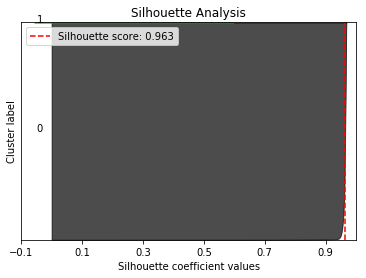

3_clusters


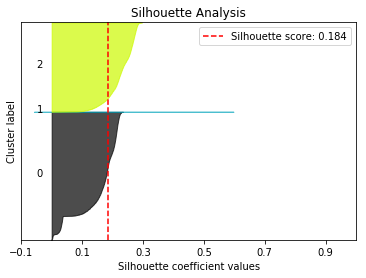

4_clusters


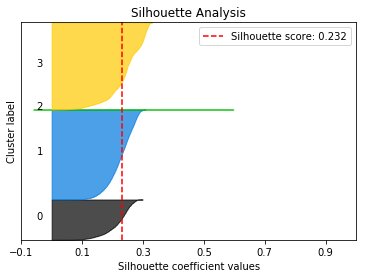

5_clusters


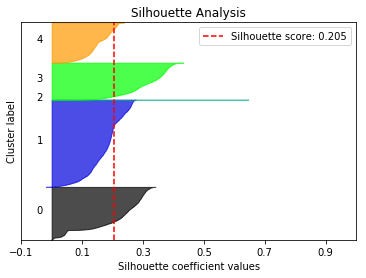

6_clusters


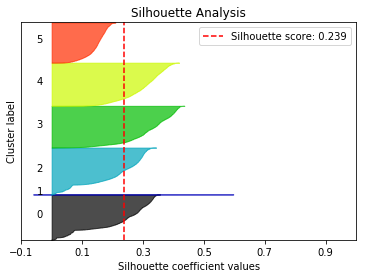

7_clusters


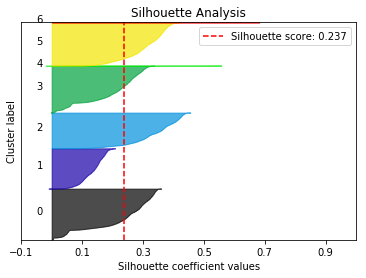

8_clusters


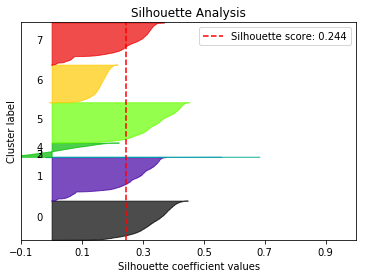

9_clusters


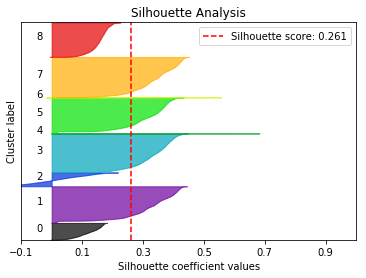

10_clusters


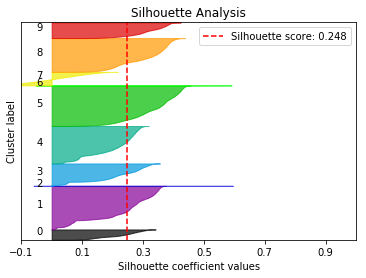

11_clusters


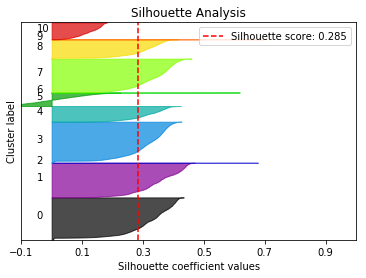

12_clusters


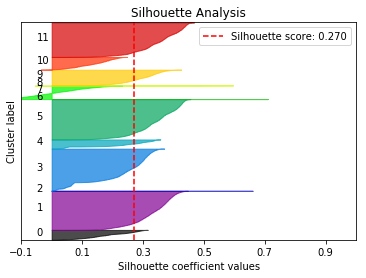

13_clusters


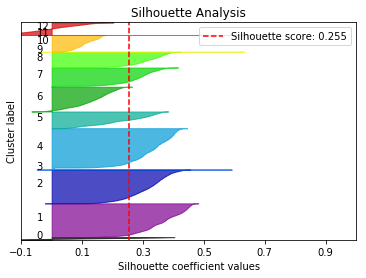

14_clusters


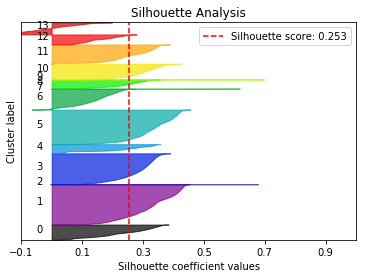

15_clusters


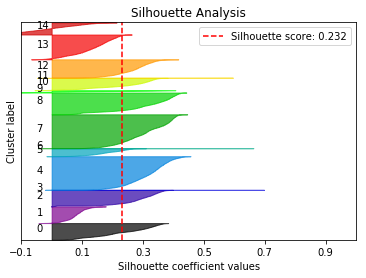

16_clusters


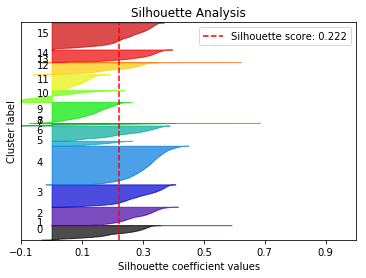

17_clusters


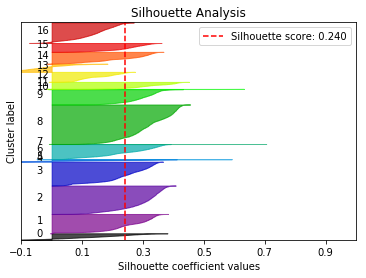

In [19]:
import scikitplot as skplt
clusters_num = range(2,18)
for j in clusters_num:
    kmeans = KMeans(n_clusters=j, init = 'k-means++', random_state=1)
    cluster_labels = kmeans.fit_predict(data_train)
    print("{}_clusters".format(j))
    skplt.metrics.plot_silhouette(data_train, cluster_labels)
    plt.savefig('SSA_{}_clusters.pdf'.format(j))
    plt.show()

In [ ]:
#=========================================GAP STATISTIC METRIC===========================================

In [20]:
#from gap_statistic import OptimalK
optimalK = OptimalK(parallel_backend='rust')
optimalK

OptimalK(n_jobs=4, parallel_backend="rust")

In [21]:
n_clusters = optimalK(data_train, cluster_array=np.arange(1, 18))
print('Optimal clusters: {} '.format(n_clusters))

Optimal clusters: 15 


In [22]:
optimalK.gap_df.head()

,n_clusters,gap_value,gap*,ref_dispersion_std,diff,diff*
0,1.0,0.375404,95777.809818,186.793271,-0.057151,106122.806519
1,2.0,0.433086,108385.820409,156.965954,-0.005087,118847.383593
2,3.0,0.438625,109607.405199,134.005744,-0.059800,121274.136835
3,4.0,0.499016,122233.832625,174.713137,0.071224,132482.147167
4,5.0,0.428341,107372.774010,162.512639,-0.088853,119398.115290


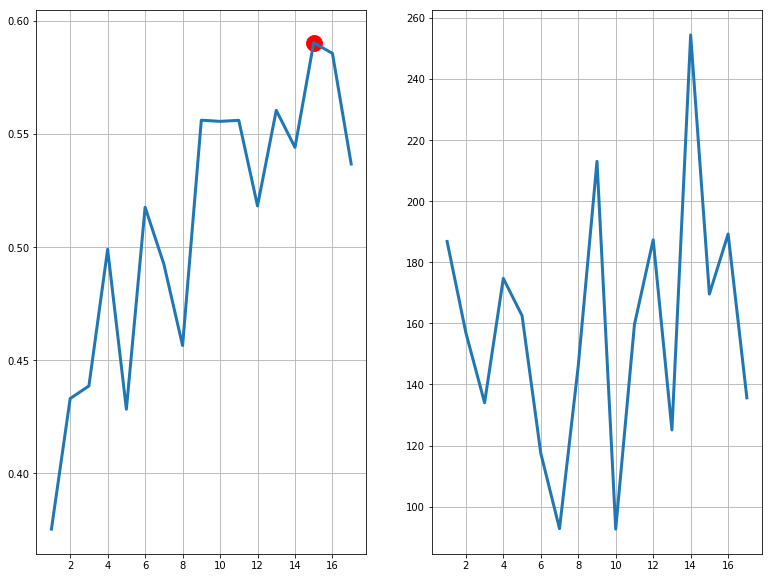

In [23]:
fig = plt.figure()
fig.set_size_inches(13, 10)
ax1 = fig.add_subplot(121)
ax1.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
ax1.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
ax1.grid(True)
#ax1.xlabel('Cluster Count')
#ax1.ylabel('Gap Value')
#ax1.title('Gap Values by Cluster Count')

ax2 = fig.add_subplot(122)
ax2.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.ref_dispersion_std, linewidth=3)
ax2.grid(True)

#ax3 = fig.add_subplot(223)
#ax3.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.diff, linewidth=3)
#ax3.grid(True)

#ax4 = fig.add_subplot(224)
#ax4.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
#ax4.grid(True)

plt.show()